# Goals

*Predict whether passengers in test data set survived Titanic. Performance measure: accuracy*

# Explore

In [367]:
import pandas as pd

In [449]:
# assuming test.csv and train.csv in the same directory where jupyter notebook is started
train = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [369]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [370]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


*There are missing values in Age, Cabin and Embarked variables*

In [371]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022080009B00>,
      dtype=object)

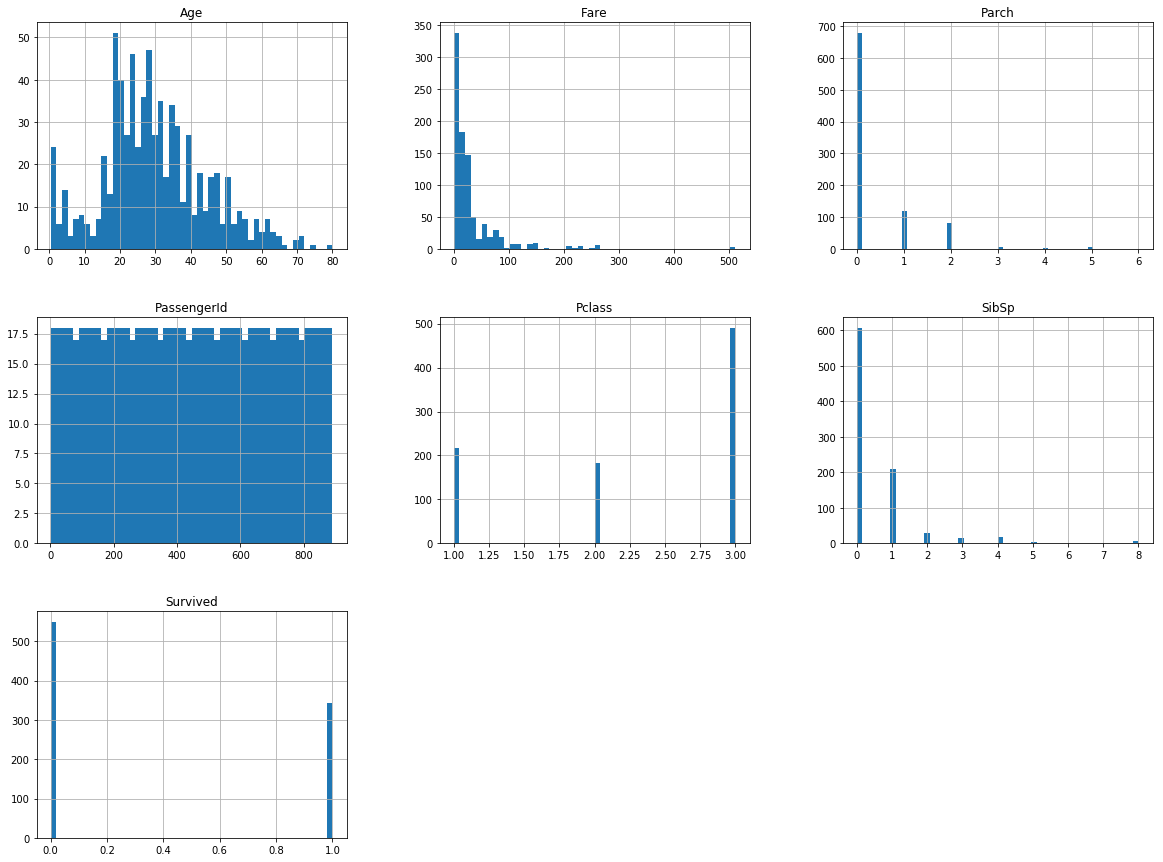

In [372]:
import matplotlib.pyplot as plt

%matplotlib inline
training.hist(bins=50, figsize=(20,15))

# Preparing data

**Numerical data**

Fare is very right skewed, needs to be log transformed.
Age is slightly right skewed, which I am going to ignore. I would create categorical variable with few bins for age. I will impute the missing ages with median of people in same passenger class.

Make boolean categorical variable out of Parch and SibSp, to see whether people had parent/children or sibling/spouse at all on board. I think the importance of exact number of those people are probably not interesting.

**Text data**

I am not going to use the variables name, ticket and cabin(lots of missing cabin) as there are too many possible values and it would be difficult to gain useful information from them.

I will make categorical variable out of sex and embarked. The missing embarked values will be imputed with mode of embarked (most common value).

 ## Transformations

In [408]:
# Values to replace the missing values
class1_median_age = train[train['Pclass']==1]["Age"].median()
class2_median_age = train[train['Pclass']==2]["Age"].median()
class3_median_age = train[train['Pclass']==3]["Age"].median()
most_frequest_embarked = train["Embarked"].mode()[0]
fare_median = train["Fare"].median()

In [409]:
# Custom transformers
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalConstantImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing values in target variable with constant grouped according to source variable category
    """
    def __init__(self, target_var: str, source_var: str, value_map: dict):
        self.target_var = target_var
        self.source_var = source_var
        self.value_map = value_map
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for category, constant in self.value_map.items():
            X.loc[(X[self.target_var].isna()) & (X[self.source_var] == category), self.target_var] = constant
        return X
    
class ZeroOneTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms values in following rule: 1 if value > 0 else 0
    """       
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X[X > 0] = 1
        return X

In [410]:
# Transformation pipeline
def _transform(df: pd.DataFrame):
    from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    
    input_df = df.copy()
    input_df["Embarked"].fillna(value = most_frequest_embarked, inplace = True)
    input_df["Fare"].fillna(value = fare_median, inplace = True)
    
    pipeline = ColumnTransformer([
        ('ordinal_encoder', OrdinalEncoder(), ["Sex", "Embarked"]),  
        ('age_imputer', 
         CategoricalConstantImputer("Age", "Pclass", {1: class1_median_age, 2: class2_median_age, 3: class3_median_age}),
         ["Age", "Pclass"]
        ),
        ('fare_transformer', PowerTransformer(), ["Fare"]),
        ('zero_one_transformer', ZeroOneTransformer(), ["SibSp", "Parch"]),
    ])

    transformed_df = pipeline.fit_transform(input_df)
    transformed_df = pd.DataFrame(transformed_df, columns = ["Sex", "Embarked", "Age", "Pclass", "Fare", "SibSp", "Parch"])
    if "Survived" in input_df.columns:
        transformed_df["Sruvived"] = input_df["Survived"]
    transformed_df.to_clipboard()
    return transformed_df

In [411]:
train_transformed = _transform(train)

## Validation set

In [412]:
# Make sure all passenger classes are similary represented in train and validation set
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, validate_index in splitter.split(train_transformed, train_transformed["Pclass"]):
    train_set = train_transformed.loc[train_index]
    validate_set = train_transformed.loc[validate_index]

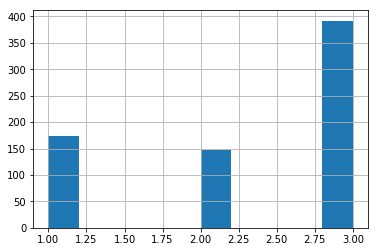

In [413]:
train_set["Pclass"].hist()

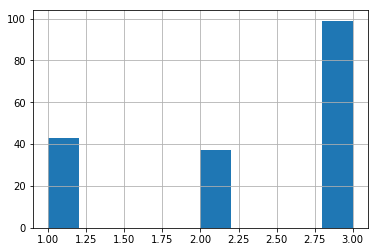

In [414]:
validate_set["Pclass"].hist()

# Train models

Logistic Regression: mean accuracy: 0.7907472613458529, accuracy sd: 0.05629957404054885
Linear Discrinminant Analysis: mean accuracy: 0.7949530516431925, accuracy sd: 0.05338001845662051
K Nearest Neighbor: mean accuracy: 0.7402777777777778, accuracy sd: 0.05357938368754622
Decision Tree Classifier: mean accuracy: 0.7655125195618153, accuracy sd: 0.052365488932092516
Gaussian Naive Bayes: mean accuracy: 0.7683098591549297, accuracy sd: 0.048324589421188384
Support Vector Machines: mean accuracy: 0.7753716744913928, accuracy sd: 0.04909867959422047


[None, None, None, None, None, None, None, None, None, None, None, None]

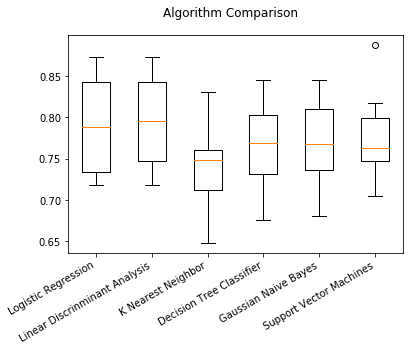

In [417]:
import warnings; warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import model_selection

#Data - use only training set. Leave out validation set for parameter tuning
array = train_set.values
X = array[:,0:7]
Y = array[:,7]

# models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Linear Discrinminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K Nearest Neighbor', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Support Vector Machines', SVC()))

# evaluate models on cross validation accuracy
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: mean accuracy: {cv_results.mean()}, accuracy sd: {cv_results.std()}")
    
# show the model comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Tuning the model

In [418]:
# Tune the best model - Logistic Regression

from sklearn.model_selection import GridSearchCV

#Data - use only validation set
array = validate_set.values
X = array[:,0:7]
Y = array[:,7]

# Parameters available for SVC
param_grid = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True)

grid.fit(X,Y)
grid.best_params_

{'C': 1.623776739188721, 'penalty': 'l2'}

In [422]:
selected_model = grid.best_estimator_
grid.best_estimator_

LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

## Feature importance

In [443]:
sorted(zip(grid.best_estimator_.coef_.flatten().tolist(), list(validate_set.columns)))

[(-1.8970596359013703, 'Sex'),
 (-0.5888807802176753, 'Pclass'),
 (-0.3186220900079177, 'Parch'),
 (-0.16679061100876014, 'Embarked'),
 (-0.019682296975605213, 'Age'),
 (0.647955656726859, 'Fare'),
 (0.6811592783420887, 'SibSp')]

*Most important feature seems to be sex followed by SibSp, Fare, Pclass and Parch*

# Predict

In [462]:
from sklearn.metrics import accuracy_score

# going through the transformation pipeline
test_transformed = _transform(test_set)

X = test_transformed.values
predictions = selected_model.predict(X)

predicted = pd.DataFrame()
predicted["PassengerId"] = test_set["PassengerId"]
predicted["Survived"] = predictions.astype(int)

# writing to the same folder where this jupyter notebook was started
predicted.to_csv("prediction.csv", index = False)